<a href="https://colab.research.google.com/github/tsilva/aiml-notebooks/blob/main/003-mlp-character-level-language-model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MLP Character-Level Language Model

This notebook is a personal reconstruction of Andrej Karpathy's lesson, [Building makemore Part 2: MLP](https://www.youtube.com/watch?v=TCH_1BHY58I). In this lesson, he improves on his previous lesson by building a flexible autoregressive character-level bigram language model using a [Multilayer Perceptron (MLP)](https://en.wikipedia.org/wiki/Multilayer_perceptron).

*The purpose of this notebook is for my own self-learning, and shouldn't add much to the original lesson beyond extra verbosity. Parts of the notebook, namely the code snippets, may have been copied from the source lesson verbatim.*

## Build the Dataset 🛠️

First, let's download a list of names:

In [522]:
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2024-09-04 15:31:59--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt.7’

names.txt.7         100%[===================>] 222.80K  --.-KB/s    in 0.004s  

2024-09-04 15:31:59 (50.7 MB/s) - ‘names.txt.7’ saved [228145/228145]



And now parse them into a list:

In [523]:
words = open("names.txt", "r").read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

Let's assign a unique integer to each possible character found in the names we parsed:

In [524]:
# Create list with all unique characters found in the raw data (sorted alphabetically)
chars = sorted(list(set(''.join(words))))

# Create lookup table for converting each possible character to a unique integer
stoi_map = {s:i+1 for i,s in enumerate(chars)}
EOS_CHAR = "." # The character used to represent the end of a word
EOS_CHAR_INDEX = 0
stoi_map[EOS_CHAR] = EOS_CHAR_INDEX # Assign index zero to EOS char

len(stoi_map), stoi_map

(27,
 {'a': 1,
  'b': 2,
  'c': 3,
  'd': 4,
  'e': 5,
  'f': 6,
  'g': 7,
  'h': 8,
  'i': 9,
  'j': 10,
  'k': 11,
  'l': 12,
  'm': 13,
  'n': 14,
  'o': 15,
  'p': 16,
  'q': 17,
  'r': 18,
  's': 19,
  't': 20,
  'u': 21,
  'v': 22,
  'w': 23,
  'x': 24,
  'y': 25,
  'z': 26,
  '.': 0})

And now create a reverse lookup table to be able to convert the integers that represent each character back to the character itself:

In [525]:
itos_map = {i:s for s,i in stoi_map.items()}
itos_map

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

We can now create the dataset we're going to use to train our model with. Given a sequence of $N$ characters, we want the model to predict the next character. Therefore, the input is going to be a list of $N$ characters, where each value in the list is the integer assigned to that character, and the output is the integer representing the next character.

Let's create a dataset where the input is a sequence of $3$ characters. Let's use only a portion of the dataset to begin with, in this case with only the first $5$ words, as it will make experimentation faster for now:

In [526]:
import torch

# The default number of characters to use to predict the next character
BLOCK_SIZE = 3

def build_dataset(words, block_size=BLOCK_SIZE, verbose=False):
  X, Y = [], [] # Initialize the dataset
  for word in words:
    if verbose: print(word)
    context = [0] * block_size # Initialize the context with EOS characters
    for char in word + EOS_CHAR: # For each character in the current word (plus the EOS stop character)
      X.append(context) # Add the context accumulated so far as the input
      char_i = stoi_map[char] # Convert the current character to an integer
      Y.append(char_i) # Add the current character as the output (previous context must predict current character)
      if verbose: print(f"{''.join([itos_map[i] for i in context])} => {char}")
      context = context[1:] + [char_i] # Update the context by popping out the oldest character and pushing in the current one (FIFO buffer)

  # Convert the dataset to tensors and return them
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  return X, Y

# Create a dataset where each character is to be predicted based on
# the last 3 characters, create it only using 5 words from the total dataset
X, Y = build_dataset(words[:5], block_size=3, verbose=True)

emma
... => e
..e => m
.em => m
emm => a
mma => .
olivia
... => o
..o => l
.ol => i
oli => v
liv => i
ivi => a
via => .
ava
... => a
..a => v
.av => a
ava => .
isabella
... => i
..i => s
.is => a
isa => b
sab => e
abe => l
bel => l
ell => a
lla => .
sophia
... => s
..s => o
.so => p
sop => h
oph => i
phi => a
hia => .


The input tensor $X$ is of shape $(32, 3)$ because the parsing of the $5$ words resulted in the collection of $32$ trigrams:

In [527]:
X.shape, X

(torch.Size([32, 3]),
 tensor([[ 0,  0,  0],
         [ 0,  0,  5],
         [ 0,  5, 13],
         [ 5, 13, 13],
         [13, 13,  1],
         [ 0,  0,  0],
         [ 0,  0, 15],
         [ 0, 15, 12],
         [15, 12,  9],
         [12,  9, 22],
         [ 9, 22,  9],
         [22,  9,  1],
         [ 0,  0,  0],
         [ 0,  0,  1],
         [ 0,  1, 22],
         [ 1, 22,  1],
         [ 0,  0,  0],
         [ 0,  0,  9],
         [ 0,  9, 19],
         [ 9, 19,  1],
         [19,  1,  2],
         [ 1,  2,  5],
         [ 2,  5, 12],
         [ 5, 12, 12],
         [12, 12,  1],
         [ 0,  0,  0],
         [ 0,  0, 19],
         [ 0, 19, 15],
         [19, 15, 16],
         [15, 16,  8],
         [16,  8,  9],
         [ 8,  9,  1]]))

The output $Y$ tensor has shape $(32)$, containing one value representing the next character for each of the $32$ character sequences found in the input tensor $X$:

In [528]:
Y.shape, Y

(torch.Size([32]),
 tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
          1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0]))

## Create Embeddings 🔍

To prepare character sequences for a neural network, it's important to avoid biases that can arise from sequential integer encoding, where higher numbers could imply greater importance (e.g., by propagating a stronger signal) or similarity (e.g., characters with close alphabetical positions might incorrectly be treated as more similar).

One-hot encoding addresses this issue by representing each character with a unique binary vector where only one element is "hot" (set to $1$), and all others are "cold" (set to $0$). However, this method cannot capture any meaningful relationships between characters (e.g., the distinction between vowels and consonants) because each vector is orthogonal to the others and can't be adjusted during training.

A more effective solution is to represent each character as a dense vector (embedding), where each character is mapped to a continuous vector with a smaller number of dimensions. Unlike one-hot encoding, these embeddings are not predefined but are instead learned during the training process along with other parameters, allowing the model to capture relationships and patterns within the data.

Let's create a tensor `C` of shape $(27, 2)$ to serve as an embedding lookup table for the $27$ possible characters:

In [529]:
C = torch.randn((27, 2))
C

tensor([[-4.2061e-01, -2.2788e+00],
        [-1.4616e-03,  9.9255e-01],
        [ 1.8368e+00, -1.1358e+00],
        [-4.3288e-01,  4.1514e-01],
        [-1.9333e+00, -2.0084e-01],
        [ 1.3398e+00,  9.7887e-01],
        [ 2.5040e-01, -1.0362e+00],
        [ 8.1175e-02,  1.7372e+00],
        [-1.6380e-01,  2.8204e-01],
        [-4.8332e-01,  1.0488e+00],
        [ 1.6645e-01,  2.6210e-04],
        [ 1.3086e+00, -1.3141e+00],
        [ 3.1752e+00, -7.3441e-01],
        [-1.8286e+00,  4.1638e-01],
        [-6.1599e-01, -4.1060e-03],
        [-1.3372e+00,  1.1549e+00],
        [ 1.8801e+00, -4.0999e-01],
        [ 2.4247e-01, -1.9184e+00],
        [-1.3885e+00, -1.0694e+00],
        [-9.1898e-01, -2.4123e+00],
        [ 1.4326e+00, -3.0937e-01],
        [ 4.5064e-01,  1.6974e+00],
        [-4.8061e-01, -2.3162e+00],
        [-4.0470e-01, -3.4926e-01],
        [ 2.9875e+00, -1.3158e+00],
        [ 1.1077e-01,  5.4974e-01],
        [ 2.2322e+00,  1.2555e+00]])

We could manually iterate through our $X$ tensor and swap all integer encoded characters with their respective embeddings, but it's much easier to do that with the power of PyTorch indexing, in fact, you can perform this replacement operation in a single call, let's learn how!

We know it's trivial to retrieve the embedding for a specific character:

In [530]:
C[5] # character "e" is represented by number "5"

tensor([1.3398, 0.9789])

And PyTorch allows retrieving multiple characters in one operation by providing a list of the indexes:

In [531]:
C[[5,6,7]] # retrieve embeddings for character sequence: "efg"

tensor([[ 1.3398,  0.9789],
        [ 0.2504, -1.0362],
        [ 0.0812,  1.7372]])

This index list could also be a tensor:

In [532]:
C[torch.tensor([5,6,7])] # retrieve embeddings for character sequence: "efg"

tensor([[ 1.3398,  0.9789],
        [ 0.2504, -1.0362],
        [ 0.0812,  1.7372]])

And the same value can be retrieved multiple times:

In [533]:
C[torch.tensor([5,6,7,7,7])] # retrieve embeddings for character sequence: "efggg"

tensor([[ 1.3398,  0.9789],
        [ 0.2504, -1.0362],
        [ 0.0812,  1.7372],
        [ 0.0812,  1.7372],
        [ 0.0812,  1.7372]])

PyTorch's powerful indexing allows you to work with N-dimensional tensors. The values in the lowest dimension of an indexing tensor are used as the indexes to access the target tensor:

In [534]:
C[torch.tensor([[[5,6,7], [8,9,10]]])] # retrieve embeddings for character sequences: "efg", "hij"

tensor([[[[ 1.3398e+00,  9.7887e-01],
          [ 2.5040e-01, -1.0362e+00],
          [ 8.1175e-02,  1.7372e+00]],

         [[-1.6380e-01,  2.8204e-01],
          [-4.8332e-01,  1.0488e+00],
          [ 1.6645e-01,  2.6210e-04]]]])

We can use N-dimensional indexing to replace the integer encodings in our input tensor $X$ (which contains character sequences) with their corresponding embeddings. To demonstrate this, let's retrieve the embedding for a specific character from a single example sequence in tensor $X$:

In [535]:
(
  X[13, 2], # retrieve integer encoding for 2nd character of 13th input character sequence
  C[X][13, 2] # retrieve embedding for 2nd character of 13th input character sequence
)

(tensor(1), tensor([-0.0015,  0.9925]))

Let's now swap all our integer encodings with embeddings in one pass:

In [536]:
Xemb = C[X]
X.shape, Xemb.shape

(torch.Size([32, 3]), torch.Size([32, 3, 2]))

We started with a `X` tensor of shape $(32, 3)$, that had $32$ character sequences, where each sequence had $3$ characters, each represented by an integer. As a result of the embedding lookup operation, we now have a `Xemb` tensor of shape $(32, 3, 2)$ because each of those integer encodings was replaced with its corresponding $2$-dimensional embedding.

## Create the MLP 🧠

A *Multilayer Perceptron* is a neural network that has at least one hidden layer. The one we're going to create will just have a single hidden layer, making it a $2$-layer network (hidden layer + output layer).

The hidden layer will have $100$ neurons (this is an arbitrary value that can be adjusted), where each neuron is connected to $6$ inputs. The $6$ inputs are derived from sequences of $3$ characters, where each character is represented by a 2-dimensional embedding vector. This requires us to create a weight matrix `W1` of shape $(6, 100)$, which holds the weights for the connections between the inputs and the neurons. Additionally, we'll create a bias vector `b1` of shape $(100)$, containing a bias value for each neuron:

In [537]:
W1 = torch.randn((6, 100)) # 6 inputs (3 characters * 2 dimensional embeddings) * 100 hidden neurons
b1 = torch.randn(100) # number of biases equal to number of neurons

Let's try running the *forward pass* through this layer:

In [538]:
try: Xemb @ W1 + b1
except Exception as e: print(e)

mat1 and mat2 shapes cannot be multiplied (96x2 and 6x100)


The *forward pass* didn't work because the input has shape $(32, 3, 2)$ and the the layer has shape $(6, 100)$. If a matrix $A$ has shape $(m, n)$ and matrix $B$ has shape $(p, q)$, it is only possible to perform matrix multiplication $A \times B$ if $n = p$, meaning that our input shape must be $(32, 6)$ for this operation to be possible.

We aim to create a vector of length $6$ for the second dimension, which will contain all the embedding values for a $3$-character sequence in order.

To retrieve the embedding for the first character in all sequences with a single call, recall that the `embeddings` tensor has a shape of $(32, 3, 2)$. The second dimension, with a length of $3$, represents the position of the characters in the sequence. By indexing a specific value in this dimension, we can extract the embeddings for that particular character position across all examples, without collapsing the other dimensions:

In [539]:
t1 = Xemb[:, 0, :] # Grab embeddings for 1st character from all 3-character input sequences
t1.shape, t1

(torch.Size([32, 2]),
 tensor([[-4.2061e-01, -2.2788e+00],
         [-4.2061e-01, -2.2788e+00],
         [-4.2061e-01, -2.2788e+00],
         [ 1.3398e+00,  9.7887e-01],
         [-1.8286e+00,  4.1638e-01],
         [-4.2061e-01, -2.2788e+00],
         [-4.2061e-01, -2.2788e+00],
         [-4.2061e-01, -2.2788e+00],
         [-1.3372e+00,  1.1549e+00],
         [ 3.1752e+00, -7.3441e-01],
         [-4.8332e-01,  1.0488e+00],
         [-4.8061e-01, -2.3162e+00],
         [-4.2061e-01, -2.2788e+00],
         [-4.2061e-01, -2.2788e+00],
         [-4.2061e-01, -2.2788e+00],
         [-1.4616e-03,  9.9255e-01],
         [-4.2061e-01, -2.2788e+00],
         [-4.2061e-01, -2.2788e+00],
         [-4.2061e-01, -2.2788e+00],
         [-4.8332e-01,  1.0488e+00],
         [-9.1898e-01, -2.4123e+00],
         [-1.4616e-03,  9.9255e-01],
         [ 1.8368e+00, -1.1358e+00],
         [ 1.3398e+00,  9.7887e-01],
         [ 3.1752e+00, -7.3441e-01],
         [-4.2061e-01, -2.2788e+00],
         [-4.206

The result is a tensor of shape $(32, 2)$, representing the embeddings for the first character in each of the $32$ $3$-character sequences in the embedded input tensor. To retrieve the embeddings for all three characters in each sequence, we could simply perform this operation for each of the $3$ characters:

In [540]:
c0 = Xemb[:, 0, :] # For all character sequences, grab the embedding for the 1st character in the sequence
c1 = Xemb[:, 1, :] # For all character sequences, grab the embedding for the 2nd character in the sequence
c2 = Xemb[:, 2, :] # For all character sequences, grab the embedding for the 3rd character in the sequence
c0.shape, c0

(torch.Size([32, 2]),
 tensor([[-4.2061e-01, -2.2788e+00],
         [-4.2061e-01, -2.2788e+00],
         [-4.2061e-01, -2.2788e+00],
         [ 1.3398e+00,  9.7887e-01],
         [-1.8286e+00,  4.1638e-01],
         [-4.2061e-01, -2.2788e+00],
         [-4.2061e-01, -2.2788e+00],
         [-4.2061e-01, -2.2788e+00],
         [-1.3372e+00,  1.1549e+00],
         [ 3.1752e+00, -7.3441e-01],
         [-4.8332e-01,  1.0488e+00],
         [-4.8061e-01, -2.3162e+00],
         [-4.2061e-01, -2.2788e+00],
         [-4.2061e-01, -2.2788e+00],
         [-4.2061e-01, -2.2788e+00],
         [-1.4616e-03,  9.9255e-01],
         [-4.2061e-01, -2.2788e+00],
         [-4.2061e-01, -2.2788e+00],
         [-4.2061e-01, -2.2788e+00],
         [-4.8332e-01,  1.0488e+00],
         [-9.1898e-01, -2.4123e+00],
         [-1.4616e-03,  9.9255e-01],
         [ 1.8368e+00, -1.1358e+00],
         [ 1.3398e+00,  9.7887e-01],
         [ 3.1752e+00, -7.3441e-01],
         [-4.2061e-01, -2.2788e+00],
         [-4.206

Now that we have three tensors, each of shape $(32, 2)$, representing the embeddings for each character across all sequences, we can concatenate them along the columns (dimension $1$). This operation will combine the embeddings for each sequence into a single tensor of shape $(32, 6)$:

In [541]:
chars_embedded = torch.cat([c0, c1, c2], dim=1) # Concatenate all tensors of shape (32, 2) along dimension 1, resulting in shape (32, 6) -- 2 + 2 + 2 = 6
chars_embedded.shape, chars_embedded

(torch.Size([32, 6]),
 tensor([[-4.2061e-01, -2.2788e+00, -4.2061e-01, -2.2788e+00, -4.2061e-01,
          -2.2788e+00],
         [-4.2061e-01, -2.2788e+00, -4.2061e-01, -2.2788e+00,  1.3398e+00,
           9.7887e-01],
         [-4.2061e-01, -2.2788e+00,  1.3398e+00,  9.7887e-01, -1.8286e+00,
           4.1638e-01],
         [ 1.3398e+00,  9.7887e-01, -1.8286e+00,  4.1638e-01, -1.8286e+00,
           4.1638e-01],
         [-1.8286e+00,  4.1638e-01, -1.8286e+00,  4.1638e-01, -1.4616e-03,
           9.9255e-01],
         [-4.2061e-01, -2.2788e+00, -4.2061e-01, -2.2788e+00, -4.2061e-01,
          -2.2788e+00],
         [-4.2061e-01, -2.2788e+00, -4.2061e-01, -2.2788e+00, -1.3372e+00,
           1.1549e+00],
         [-4.2061e-01, -2.2788e+00, -1.3372e+00,  1.1549e+00,  3.1752e+00,
          -7.3441e-01],
         [-1.3372e+00,  1.1549e+00,  3.1752e+00, -7.3441e-01, -4.8332e-01,
           1.0488e+00],
         [ 3.1752e+00, -7.3441e-01, -4.8332e-01,  1.0488e+00, -4.8061e-01,
          -2

The main issue with this approach is that it's hardcoded for sequences that are exactly $3$ characters long. To make it more flexible and generalize it to sequences of any length, we can use `torch.unbind()` to split a tensor along a specified dimension:

In [542]:
cn = torch.unbind(Xemb, dim=1)
len(cn), cn[0].shape

(3, torch.Size([32, 2]))

We now have the same $3$ tensors of shape $(32, 2)$ with a single call. Let's concatenate their rows:

In [543]:
chars_embedded = torch.cat(cn, dim=1) # Concatenate all tensors of shape (32, 2) along dimension 1 (columns), resulting in shape (32, 6) -- 2 + 2 + 2 = 6
chars_embedded.shape, chars_embedded

(torch.Size([32, 6]),
 tensor([[-4.2061e-01, -2.2788e+00, -4.2061e-01, -2.2788e+00, -4.2061e-01,
          -2.2788e+00],
         [-4.2061e-01, -2.2788e+00, -4.2061e-01, -2.2788e+00,  1.3398e+00,
           9.7887e-01],
         [-4.2061e-01, -2.2788e+00,  1.3398e+00,  9.7887e-01, -1.8286e+00,
           4.1638e-01],
         [ 1.3398e+00,  9.7887e-01, -1.8286e+00,  4.1638e-01, -1.8286e+00,
           4.1638e-01],
         [-1.8286e+00,  4.1638e-01, -1.8286e+00,  4.1638e-01, -1.4616e-03,
           9.9255e-01],
         [-4.2061e-01, -2.2788e+00, -4.2061e-01, -2.2788e+00, -4.2061e-01,
          -2.2788e+00],
         [-4.2061e-01, -2.2788e+00, -4.2061e-01, -2.2788e+00, -1.3372e+00,
           1.1549e+00],
         [-4.2061e-01, -2.2788e+00, -1.3372e+00,  1.1549e+00,  3.1752e+00,
          -7.3441e-01],
         [-1.3372e+00,  1.1549e+00,  3.1752e+00, -7.3441e-01, -4.8332e-01,
           1.0488e+00],
         [ 3.1752e+00, -7.3441e-01, -4.8332e-01,  1.0488e+00, -4.8061e-01,
          -2

We obtained our desired tensor of shape $(32, 6)$ using a straightforward method, but there's an even more efficient way to achieve this by utilizing the `view()` function in tensors.

Let's create a simpler example to illustrate how this works:

In [544]:
t = torch.arange(18)
t.shape, t

(torch.Size([18]),
 tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17]))

This tensor `t` has a shape of $(18)$, but it can easily be reshaped to any other form, as long as the product of all dimensions still equals $18$. For example, we can reshape it to have a shape of $(2, 9)$:

In [545]:
t.view(2, 9)

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8],
        [ 9, 10, 11, 12, 13, 14, 15, 16, 17]])

Or reshape it to $(9, 2)$:

In [546]:
t.view(9, 2)

tensor([[ 0,  1],
        [ 2,  3],
        [ 4,  5],
        [ 6,  7],
        [ 8,  9],
        [10, 11],
        [12, 13],
        [14, 15],
        [16, 17]])

Or even reshape it to $(3, 3, 2)$:

In [547]:
t.view(3, 3, 2)

tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15],
         [16, 17]]])

This operation not only simplifies the process but is also highly efficient because it doesn't create any new tensors, thus avoiding additional memory allocation.

The reason this works is that tensors are stored in memory as sequential arrays and are accessed differently based on certain parameters that dictate how the data is interpreted. For more details on how tensors work internally, you can refer to this blog post: [PyTorch Internals](https://blog.ezyang.com/2019/05/pytorch-internals/).

You can inspect a tensor's raw values using the `storage()` function:

In [548]:
t.shape, t.storage()

(torch.Size([18]),
  0
  1
  2
  3
  4
  5
  6
  7
  8
  9
  10
  11
  12
  13
  14
  15
  16
  17
 [torch.storage.TypedStorage(dtype=torch.int64, device=cpu) of size 18])

We can apply the reshaping operation again using each of previous strategies and compare their results to ensure they produce equivalent outcomes:

In [549]:
t1 = torch.cat([Xemb[:, 0, :], Xemb[:, 1, :], Xemb[:, 2, :]], dim=1) # inefficient
t2 = torch.cat(torch.unbind(Xemb, 1), dim=1) # inefficient
t3 = Xemb.view(32, 6) # efficient
torch.equal(t1, t2), torch.equal(t2, t3)

(True, True)

One important detail to explore is how to make the reshaping process more flexible. Currently, it's hardcoded for $32$ examples, but we can make it adaptable by softcoding it as follows:

In [550]:
Xemb.view(Xemb.shape[0], 6)

tensor([[-4.2061e-01, -2.2788e+00, -4.2061e-01, -2.2788e+00, -4.2061e-01,
         -2.2788e+00],
        [-4.2061e-01, -2.2788e+00, -4.2061e-01, -2.2788e+00,  1.3398e+00,
          9.7887e-01],
        [-4.2061e-01, -2.2788e+00,  1.3398e+00,  9.7887e-01, -1.8286e+00,
          4.1638e-01],
        [ 1.3398e+00,  9.7887e-01, -1.8286e+00,  4.1638e-01, -1.8286e+00,
          4.1638e-01],
        [-1.8286e+00,  4.1638e-01, -1.8286e+00,  4.1638e-01, -1.4616e-03,
          9.9255e-01],
        [-4.2061e-01, -2.2788e+00, -4.2061e-01, -2.2788e+00, -4.2061e-01,
         -2.2788e+00],
        [-4.2061e-01, -2.2788e+00, -4.2061e-01, -2.2788e+00, -1.3372e+00,
          1.1549e+00],
        [-4.2061e-01, -2.2788e+00, -1.3372e+00,  1.1549e+00,  3.1752e+00,
         -7.3441e-01],
        [-1.3372e+00,  1.1549e+00,  3.1752e+00, -7.3441e-01, -4.8332e-01,
          1.0488e+00],
        [ 3.1752e+00, -7.3441e-01, -4.8332e-01,  1.0488e+00, -4.8061e-01,
         -2.3162e+00],
        [-4.8332e-01,  1.0488e

There's an even more flexible approach: by setting `-1` in the first dimension, we let PyTorch automatically calculate its size. With $192$ elements and the second dimension fixed at $6$, PyTorch determines the first dimension should be $32$ since $32 \times 6 = 192$:

In [551]:
Xemb.view(-1, 6)

tensor([[-4.2061e-01, -2.2788e+00, -4.2061e-01, -2.2788e+00, -4.2061e-01,
         -2.2788e+00],
        [-4.2061e-01, -2.2788e+00, -4.2061e-01, -2.2788e+00,  1.3398e+00,
          9.7887e-01],
        [-4.2061e-01, -2.2788e+00,  1.3398e+00,  9.7887e-01, -1.8286e+00,
          4.1638e-01],
        [ 1.3398e+00,  9.7887e-01, -1.8286e+00,  4.1638e-01, -1.8286e+00,
          4.1638e-01],
        [-1.8286e+00,  4.1638e-01, -1.8286e+00,  4.1638e-01, -1.4616e-03,
          9.9255e-01],
        [-4.2061e-01, -2.2788e+00, -4.2061e-01, -2.2788e+00, -4.2061e-01,
         -2.2788e+00],
        [-4.2061e-01, -2.2788e+00, -4.2061e-01, -2.2788e+00, -1.3372e+00,
          1.1549e+00],
        [-4.2061e-01, -2.2788e+00, -1.3372e+00,  1.1549e+00,  3.1752e+00,
         -7.3441e-01],
        [-1.3372e+00,  1.1549e+00,  3.1752e+00, -7.3441e-01, -4.8332e-01,
          1.0488e+00],
        [ 3.1752e+00, -7.3441e-01, -4.8332e-01,  1.0488e+00, -4.8061e-01,
         -2.3162e+00],
        [-4.8332e-01,  1.0488e

With that out of the way let's finally run the *forward pass* for the first layer (the hidden layer):

In [552]:
h1 = Xemb.view(-1, 6) @ W1 + b1
h1.shape, h1

(torch.Size([32, 100]),
 tensor([[-4.5821,  3.3886,  8.3542,  ..., -1.6908, -1.4761, -1.3896],
         [-0.7359,  4.3256,  5.5844,  ..., -2.0712,  0.9985,  4.1693],
         [-4.4854,  6.9301, -1.6082,  ..., -3.2926,  2.7513, -1.7095],
         ...,
         [ 3.8118,  2.8222,  3.9976,  ..., -2.6320,  5.2659,  0.6684],
         [-2.5701,  0.3696, -3.8014,  ...,  3.0659, -0.4773, -2.0006],
         [-1.1837,  0.4894, -4.5214,  ..., -2.8452,  0.2084, -0.0983]]))

We're still missing a non-linear function to squash the layer's activation, let's use `tanh`:

In [553]:
h1 = torch.tanh(Xemb.view(-1, 6) @ W1 + b1)
h1.shape, h1

(torch.Size([32, 100]),
 tensor([[-0.9998,  0.9977,  1.0000,  ..., -0.9342, -0.9007, -0.8831],
         [-0.6267,  0.9997,  1.0000,  ..., -0.9687,  0.7610,  0.9995],
         [-0.9997,  1.0000, -0.9229,  ..., -0.9972,  0.9919, -0.9366],
         ...,
         [ 0.9990,  0.9930,  0.9993,  ..., -0.9897,  0.9999,  0.5839],
         [-0.9884,  0.3536, -0.9990,  ...,  0.9957, -0.4440, -0.9641],
         [-0.8286,  0.4537, -0.9998,  ..., -0.9933,  0.2054, -0.0980]]))

Next, we'll create the second and final layer, the *output layer*.

Since the previous layer has $100$ neurons, it outputs $100$ values, meaning the *output layer* will have $100$ inputs. To output probabilities for each of the $27$ possible characters, it will need $27$ neurons. Therefore, the weight matrix `W2` for the *output layer* will have a shape of $(100, 27)$, representing $100 \times 27 = 2700$ weights.

We'll also create a tensor `b2` of shape $(27)$ for the bias values of the output neurons:

In [554]:
W2 = torch.randn((100, 27)) # Create output layer (receives 100 inputs from previous layer, and outputs 27 for the possible next character)
b2 = torch.randn(27) # Add a bias to each of the possible outputs

We can now continue the *forward pass* through the *output layer* to get the logits:

In [555]:
logits = h1 @ W2 + b2
logits.shape

torch.Size([32, 27])

The `logits` tensor has a shape of $(32, 27)$ because it represents the unnormalized scores (raw predictions) for each possible next character across the $32$ input character sequences fed into the network.

Let's inspect the `logits` tensor:

In [556]:
logits.shape, logits[0]

(torch.Size([32, 27]),
 tensor([-17.1940,   3.4736, -13.7481,  18.1992, -12.1185,  18.9400, -11.9435,
          -2.7839, -12.4418, -20.0452,  22.3156,  -6.9423, -15.3579,   3.3752,
         -11.5236,   9.5172,  -7.9597,  -7.7149,   8.2347,  -8.1456,  -7.4891,
          -2.1093,   8.4081,   4.7288,  -9.2167,  10.6841,   1.7673]))

To convert the negative numbers into positive ones and prepare the logits for normalization into a probability distribution, we can exponentiate the logits. This will turn them positive (a requirement for normalization), while amplifying the differences between higher and lower values (for faster training):

In [557]:
counts = logits.exp()
counts.shape, counts[0]

(torch.Size([32, 27]),
 tensor([3.4097e-08, 3.2254e+01, 1.0697e-06, 8.0129e+07, 5.4574e-06, 1.6808e+08,
         6.5012e-06, 6.1799e-02, 3.9500e-06, 1.9701e-09, 4.9153e+09, 9.6609e-04,
         2.1387e-07, 2.9231e+01, 9.8940e-06, 1.3591e+04, 3.4927e-04, 4.4612e-04,
         3.7696e+03, 2.9000e-04, 5.5917e-04, 1.2133e-01, 4.4832e+03, 1.1316e+02,
         9.9361e-05, 4.3658e+04, 5.8551e+00]))

We can now normalize the logits to obtain a probability distribution:

In [558]:
probs = counts / counts.sum(1, keepdims=True)
probs.shape, probs[0].sum(), probs[0]

(torch.Size([32, 27]),
 tensor(1.0000),
 tensor([6.6035e-18, 6.2464e-09, 2.0717e-16, 1.5518e-02, 1.0569e-15, 3.2552e-02,
         1.2591e-15, 1.1968e-11, 7.6498e-16, 3.8153e-19, 9.5192e-01, 1.8710e-13,
         4.1419e-17, 5.6610e-09, 1.9161e-15, 2.6322e-06, 6.7642e-14, 8.6398e-14,
         7.3004e-07, 5.6162e-14, 1.0829e-13, 2.3497e-11, 8.6825e-07, 2.1915e-08,
         1.9243e-14, 8.4551e-06, 1.1339e-09]))

Using PyTorch's advanced indexing, we can retrieve the probability assigned by the model to the correct next character (found in $Y$) for each of the $32$ inputs:

In [559]:
probs[torch.arange(32), Y] # Probability for each of the possible examples being the expected character

tensor([3.2552e-02, 2.4674e-05, 1.4123e-07, 8.0032e-12, 2.8475e-10, 2.6322e-06,
        2.2335e-11, 1.8446e-12, 2.4507e-07, 5.7547e-16, 6.6817e-15, 3.4337e-07,
        6.2464e-09, 9.4887e-01, 1.3744e-09, 3.9650e-09, 3.8153e-19, 6.2392e-06,
        7.5112e-09, 4.7126e-14, 9.2577e-06, 3.7270e-03, 1.6060e-07, 5.2157e-12,
        2.1482e-04, 5.6162e-14, 6.8547e-06, 8.5558e-11, 1.4128e-10, 1.6863e-06,
        2.6734e-11, 4.4876e-08])

We can now calculate the *negative log likelihood* and use it as our loss function:

In [560]:
nll_loss = -probs[torch.arange(32), Y].log().mean()
nll_loss

tensor(19.1288)

## Improve Numerical Stability ⚖️

Let's discuss the benefits of using `F.cross_entropy()` from PyTorch instead of manually calculating the *negative log likelihood*.

First, let's define a `build_model()` function that allows us to recreate our model whenever needed with the same initial parameters when needed:

In [561]:
SEED = 42 # Default seed to initialize random number generators with, for reproducibility

def build_model(seed=SEED):
  generator = torch.Generator().manual_seed(seed) # Use a generator so that we always get the same model with the same parameters
  C = torch.randn((27, 2), generator=generator)
  W1 = torch.randn((6, 100), generator=generator)
  b1 = torch.randn(100, generator=generator)
  W2 = torch.randn((100, 27), generator=generator)
  b2 = torch.randn(27, generator=generator)
  parameters = [C, W1, b1, W2, b2]
  for p in parameters: p.requires_grad = True # Enable gradient tracking
  return parameters

model = build_model() # Create the model
C, W1, b1, W2, b2 = model # Unpack the model parameters

# Count the number of parameters
num_parameters = sum(p.nelement() for p in model)
print(f"Number of parameters: {num_parameters}")

Number of parameters: 3481


Now, let's encapsulate the forward pass into a `forward()` method:

In [562]:
import torch.nn.functional as F

def forward(dataset, model, loss_fn="F.cross_entropy"):
  X, Y = dataset # Unpack the dataset
  C, W1, b1, W2, b2 = model # Unpack the model parameters

  Xemb = C[X] # Embed X tensor (replaces character integer encoding with embeddings)
  h = torch.tanh(Xemb.view(-1, 6) @ W1 + b1) # Activate hidden layer, resulting in (32, 100)
  logits = h @ W2 + b2 # Activate output layer, resulting in (32, 27)

  # Run efficient pytorch cross-entropy loss function by default
  if loss_fn == "F.cross_entropy":
    loss = F.cross_entropy(logits, Y)
  # Otherwise calculate same loss function manually
  else:
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdims=True)
    loss = -probs[torch.arange(Xemb.shape[0]), Y].log().mean()

  return loss, logits

First we run the *forward pass* with our manual loss calculation:

In [563]:
dataset = (X, Y)
loss, _ = forward(dataset, model, loss_fn="manual")
loss

tensor(17.7758, grad_fn=<NegBackward0>)

And now we use PyTorch's `F.cross_entropy` loss function:

In [564]:
loss, _ = forward(dataset, model, loss_fn="F.cross_entropy")
loss

tensor(17.7758, grad_fn=<NllLossBackward0>)

We were fortunate to achieve the same loss with both approaches, but this might not always be the case. Let's explore an edge case where certain logits can cause numerical instability in our manual loss calculation.

First, consider a stable example:

In [565]:
# Define temporary function to manually
# calculate probabilities for testing purposes
def _calc_probs(logits):
  counts = logits.exp()
  probs = counts / counts.sum()
  return {
      "counts" : counts,
      "probs" : probs
  }

_calc_probs(torch.tensor([-2.0, -3.0, 0.0, -5.0]))

{'counts': tensor([0.1353, 0.0498, 1.0000, 0.0067]),
 'probs': tensor([0.1135, 0.0418, 0.8390, 0.0057])}

Everything was fine with the previous calculation, and everything should still be fine if we had big negative logits:

In [566]:
_calc_probs(torch.tensor([-100.0, -3.0, 0.0, 5.0]))

{'counts': tensor([3.7835e-44, 4.9787e-02, 1.0000e+00, 1.4841e+02]),
 'probs': tensor([0.0000e+00, 3.3311e-04, 6.6906e-03, 9.9298e-01])}

But if we had big positive logits we would not be so lucky:

In [567]:
_calc_probs(torch.tensor([-100.0, -3.0, 0.0, 100.0]))

{'counts': tensor([3.7835e-44, 4.9787e-02, 1.0000e+00,        inf]),
 'probs': tensor([0., 0., 0., nan])}

We observed that the `counts` tensor contains a positive infinity, and the `probs` tensor has a `NaN` value. This issue arises because the exponentiation of large numbers can lead to extremely large values, which may exceed the representable range of the data types, resulting in overflow.

To illustrate this, let's plot the `exp()` function over the range $[-100, 100]$. This will help us visualize how exponentiating large numbers can lead to such overflow issues:

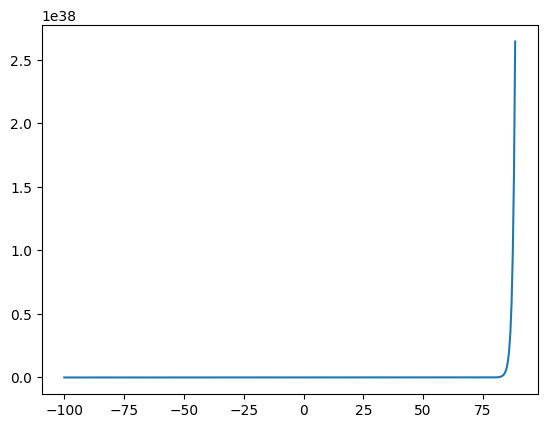

In [568]:
from matplotlib import pyplot as plt
px = torch.linspace(-100, 100, 400) # Plot 400 points in range [-100, 100]
py = torch.exp(px) # Calculate exp() for each x value
plt.plot(px, py) # Plot the values

Exponentiation remains stable while $X <= 88$, after which the $Y$ value explodes and becomes unrepresentable:

In [569]:
torch.exp(torch.tensor(88)), torch.exp(torch.tensor(89))

(tensor(1.6516e+38), tensor(inf))

There is an easy solution to this overflow problem though. Since the normalization step adjusts the distribution of values, the actual values passed to it are less important as long as their relative distribution remains the same.

Notice how adding or subtracting constants from the logits tensor yields the same normalized result:

In [570]:
for value in [0, -1, 1, -2, 2, -10, 10]:
  result = _calc_probs(torch.tensor([-2.0, -3.0, 0.0, -5.0]) + value)
  print(result["probs"])

tensor([0.1135, 0.0418, 0.8390, 0.0057])
tensor([0.1135, 0.0418, 0.8390, 0.0057])
tensor([0.1135, 0.0418, 0.8390, 0.0057])
tensor([0.1135, 0.0418, 0.8390, 0.0057])
tensor([0.1135, 0.0418, 0.8390, 0.0057])
tensor([0.1135, 0.0418, 0.8390, 0.0057])
tensor([0.1135, 0.0418, 0.8390, 0.0057])


Therefore, to mitigate the numerical instability during exponentiation, we just need to subtract the maximum logit value from the tensor. This adjustment allows us to achieve the same result while avoiding overflow issues:

In [571]:
_calc_probs(torch.tensor([-100.0, -3.0, 0.0, 100.0]) - 100.0)

{'counts': tensor([0.0000e+00, 1.4013e-45, 3.7835e-44, 1.0000e+00]),
 'probs': tensor([0.0000e+00, 1.4013e-45, 3.7835e-44, 1.0000e+00])}

The `F.cross_entropy()` function in PyTorch enhances numerical stability by combining *log-softmax* and *negative log-likelihood* into one step. It subtracts the maximum logit before softmax to prevent overflow, ensuring stable and accurate results. Since not only more reliable but faster, we'll be using it instead from now on.

## Train on Partial Dataset 🏋️‍♂️

Let's create the model again to train it from scratch:

In [572]:
model = build_model()

Now let's define the training function and run it for a few steps:

In [573]:
def train(dataset, model, n_steps, learning_rate=0.1, verbose=False):
  for step in range(n_steps):
    loss, logits = forward(dataset, model)
    if verbose: print(f"step: {step}, loss={loss}")

    # Perform backpropagation
    for p in model: p.grad = None
    loss.backward()

    # Perform gradient descent
    for p in model: p.data -= learning_rate * p.grad

  # Return loss and final logits
  return loss, logits

loss, _ = train(dataset, model, 10, learning_rate=1, verbose=True)
loss

step: 0, loss=17.775842666625977
step: 1, loss=9.489405632019043
step: 2, loss=6.31451940536499
step: 3, loss=4.218498229980469
step: 4, loss=3.1028294563293457
step: 5, loss=1.657302975654602
step: 6, loss=1.6401607990264893
step: 7, loss=1.6740186214447021
step: 8, loss=2.21173095703125
step: 9, loss=1.4576846361160278


tensor(1.4577, grad_fn=<NllLossBackward0>)

It's converging, but you can start noticing some instability in the last few steps.

Let's continue training with a lower learning rate:

In [574]:
loss, logits = train(dataset, model, 20, learning_rate=0.1, verbose=True)
loss

step: 0, loss=1.0502263307571411
step: 1, loss=0.9460259079933167
step: 2, loss=0.8787636160850525
step: 3, loss=0.822243332862854
step: 4, loss=0.7705267667770386
step: 5, loss=0.7216517925262451
step: 6, loss=0.6745641827583313
step: 7, loss=0.6287581324577332
step: 8, loss=0.5841146111488342
step: 9, loss=0.5408188700675964
step: 10, loss=0.49929147958755493
step: 11, loss=0.46011513471603394
step: 12, loss=0.42397618293762207
step: 13, loss=0.39163923263549805
step: 14, loss=0.36388885974884033
step: 15, loss=0.34136030077934265
step: 16, loss=0.3242487907409668
step: 17, loss=0.3120889365673065
step: 18, loss=0.3038617670536041
step: 19, loss=0.29838013648986816


tensor(0.2984, grad_fn=<NllLossBackward0>)

It's easy to achieve a low loss because we are training a model with a lot of parameters on just a few examples. For this reason, the model can easily overfit the data. Interestingly, we can't reduce the loss to zero, suggesting that some sequences are not learnable.

Let's retrieve the maximum logit activations for each example and compare them with the labels $Y$ to identify which sequences are being misclassified:

In [575]:
logits.max(dim=1) # This returns the maximum value for each row (max along the columns dimension)

torch.return_types.max(
values=tensor([ 9.4951, 13.1345, 15.0723, 16.9269, 25.8626,  9.4951, 13.2594, 26.4025,
        16.9143, 18.4625, 14.0319, 19.1883,  9.4951, 15.8460, 16.9449, 22.0483,
         9.4951, 12.5316, 14.8274, 16.4057, 16.7011, 18.3765, 16.9052, 15.6323,
        24.3389,  9.4951, 12.5404, 11.8761, 15.2975, 17.5801, 15.9891, 22.8013],
       grad_fn=<MaxBackward0>),
indices=tensor([ 9, 13, 13,  1,  0,  9, 12,  9, 22,  9,  1,  0,  9, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0,  9, 15, 16,  8,  9,  1,  0]))

Notice that we not only obtained the maximum logit values for each example, but we also retrieved the indices where those values were found. Let's compare those indices with $Y$ side by side:

In [576]:
logits.max(1).indices, Y, logits.max(1).indices != Y

(tensor([ 9, 13, 13,  1,  0,  9, 12,  9, 22,  9,  1,  0,  9, 22,  1,  0,  9, 19,
          1,  2,  5, 12, 12,  1,  0,  9, 15, 16,  8,  9,  1,  0]),
 tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
          1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0]),
 tensor([ True, False, False, False, False,  True, False, False, False, False,
         False, False,  True, False, False, False, False, False, False, False,
         False, False, False, False, False,  True, False, False, False, False,
         False, False]))

Now that we've identified the failed predictions, let's use some PyTorch advanced indexing to retrieve the mismatched input sequences.

We can use a boolean tensor to specify which values we want to retrieve from another tensor:

In [577]:
torch.tensor([1, 2, 3, 4])[torch.tensor([True, False, True, False])]

tensor([1, 3])

Since our boolean tensor has a `True` for each input sequence where the next character was predicted incorrectly and `False` for correct predictions, we can use this tensor to index into the input tensor `X` and retrieve the corresponding values for all failed predictions:

In [578]:
X[logits.max(1).indices != Y]

tensor([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]])

Remember that `0` is the integer that encodes the *EOS character* `.`:

In [579]:
stoi_map['.']

0

Therefore all of the missed predictions were caused by the character sequence `...`. This makes sense because that sequence can be followed by the first letter of any name in the dataset, making it impossible to predict with $100\%$ accuracy.

## Train on Full Dataset 🚀

Now let's train on the entire dataset:

In [580]:
model = build_model() # Create model from scratch
dataset = build_dataset(words) # Create dataset with all examples (not only a subset)
X, Y = dataset # Unpack the dataset

We'll train for a few steps:

In [581]:
loss, _ = train(dataset, model, 10, verbose=True)
loss

step: 0, loss=16.726470947265625
step: 1, loss=14.942935943603516
step: 2, loss=13.863014221191406
step: 3, loss=13.003832817077637
step: 4, loss=12.292207717895508
step: 5, loss=11.732643127441406
step: 6, loss=11.270576477050781
step: 7, loss=10.859724044799805
step: 8, loss=10.479724884033203
step: 9, loss=10.136445045471191


tensor(10.1364, grad_fn=<NllLossBackward0>)

A solution to the problem of increased training time due to larger datasets is to use **Stochastic Gradient Descent (SGD)** instead of vanilla gradient descent. Instead of updating parameters based on the entire dataset, in each iteration, a mini-batch is sampled, and gradients are computed for that subset.

This approach offers much better scalability, as training remains feasible as long as the batch size fits in memory, even with very large datasets. Although the gradients calculated from each mini-batch may not be perfect, they are still effective enough to guide the descent. This method has additional benefits, such as helping avoid local minima by introducing variation in the gradient at each step. This variability can also make overfitting less likely since an overfitted model typically is one that converged to a local minimum.

To create a mini-batch, we randomly generate a list of indices corresponding to the batch size and retrieve the associated subset of the dataset. First, let's learn how to generate a random tensor with values within a specific range. For example, we can generate a tensor of shape $(10)$ with values in the range $[0,5]$:



In [582]:
torch.randint(0, 5, (10,))

tensor([0, 2, 1, 3, 2, 3, 2, 4, 0, 4])

Now let's apply the same approach to our dataset. To sample a mini-batch of $32$ examples, we need a tensor of shape $(32)$ with values ranging from zero to the maximum index in the `X` input tensor, which corresponds to the first dimension of its shape:

In [583]:
batch_indexes = torch.randint(0, X.shape[0], (32,))
X.shape[0], len(batch_indexes), batch_indexes

(228146,
 32,
 tensor([102653,  70454, 161541, 121652, 111574, 125988,  80159,  33049, 212482,
          72000,  43887,  36030, 184134, 134115,  77447, 142283, 222782, 213097,
         116753,  98019,  31424,  55789, 120850, 186081,  30630, 128744,  38183,
         125341,  10651,  39416, 204288,  87622]))

Now, use those indices to retrieve the sampled mini-batch from the `X` input tensor:

In [584]:
Xbt, Ybt = X[batch_indexes], Y[batch_indexes]
Xbt.shape, Ybt.shape

(torch.Size([32, 3]), torch.Size([32]))

Let's modify the training function to implement *Stochastic Gradient Descent (SGD)* instead:

([<matplotlib.lines.Line2D at 0x7ae1907599f0>], 2.4568216800689697)

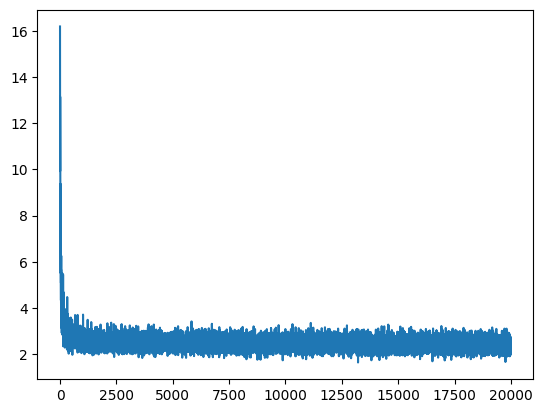

In [585]:
def train(dataset, model, n_steps, learning_rate=0.1, batch_size=32, verbose=False):
  # Unpack the dataset
  X, Y = dataset

  # Train for N steps
  losses = []
  for step in range(n_steps):
    batch_indexes = torch.randint(0, X.shape[0], (batch_size,))
    Xbt, Ybt = X[batch_indexes], Y[batch_indexes]
    loss, logits = forward((Xbt, Ybt), model)
    if verbose: print(f"step: {step}, loss={loss}")

    # Perform backpropagation
    for p in model: p.grad = None
    loss.backward()

    # Perform gradient descent
    _learning_rate = learning_rate(step) if callable(learning_rate) else learning_rate
    for p in model: p.data -= _learning_rate * p.grad

    # Track stats
    losses.append(loss.item())

  return losses, logits

model = build_model() # Create model from scratch
losses, _ = train(dataset, model, 20_000) # Train for 20k steps on the entire dataset
plt.plot(losses), losses[-1] # Plot the losses during training and output the loss at the last step

Let's evaluate the loss for the entire dataset (the losses we monitored during training were mini-batch losses):

In [586]:
loss, _ = forward(dataset, model)
loss

tensor(2.4451, grad_fn=<NllLossBackward0>)

We achieved a loss of $2.43$, which is already a great result! As a benchmark, the best loss we obtained for the simple model we trained in the previous notebook, [Character-Level Bigram Language Model](https://github.com/tsilva/aiml-notebooks/blob/main/002-character-level-bigram-language-model.ipynb), was $2.45$. This means we've already surpassed our previous attempt, and there's still room for improvement.

## Tune the Learning Rate 🎛️

Selecting optimal learning rate is crucial for faster convergence and better results. Since the ideal learning rate can vary depending on the problem, a practical approach is to experiment with different values.

Let's generate $1000$ learning rate exponents $e$ within the range $[-3, 0]$, and compute the corresponding learning rates, where the learning rate is given by $10^e$.

In [587]:
learning_rate_exponents = torch.linspace(-3, 0, 1000) # Generate 1000 exponents in range [-3, 0]
learning_rates = 10**learning_rate_exponents # Calculate the learning rate for each exponent
learning_rate_exponents[:5], learning_rates[:5] # Print a slice of the exponents and corresponding learning rates side by side

(tensor([-3.0000, -2.9970, -2.9940, -2.9910, -2.9880]),
 tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010]))

We'll train a new model for $1000$ steps, selecting one of the calculated learning rates at each step. After training, we'll plot the loss against each corresponding learning rate exponent:

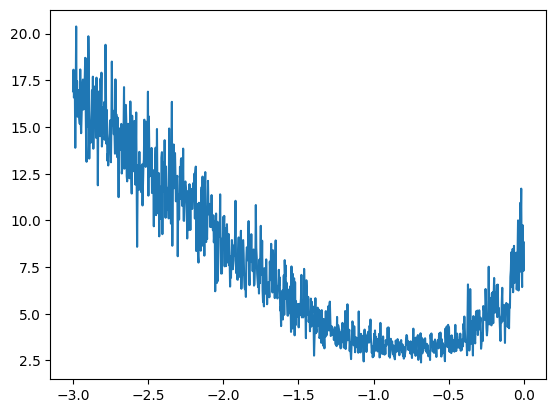

In [588]:
model = build_model() # Create the model from scratch to start with the untrained parameters
losses, _ = train(dataset, model, 1000, learning_rate=lambda step:learning_rates[step]) # Train for 1k steps with a different learning rate at each step
plt.plot(learning_rate_exponents, losses) # Plot the loss for each learning rate exponent

We observe the loss decreasing as the learning rate exponent increases. This is expected, as a higher exponent improves convergence speed, and each new learning rate is applied at the next step, allowing the model to naturally improve through backpropagation and gradient descent.

What we're really interested in is the point just before the loss starts worsening as the exponent increases. According to the graph, the loss begins to worsen around an exponent of $-0.5$, suggesting that the optimal range is between $-1$ and $-0.5$.

Thus, $-1$ is a strong candidate for the learning rate exponent, giving us a learning rate of $10^{-1} = 0.1$ (which is actually the default we started with).

Let's train for a while using that learning rate and see what loss we get on the entire dataset:

In [589]:
model = build_model() # Create fresh new model
train(dataset, model, 20_000, learning_rate=10**-1) # Train for 20k steps with the learning rate we discovered
loss = forward(dataset, model)[0] # Calculate the loss for the entire dataset
loss

tensor(2.4110, grad_fn=<NllLossBackward0>)

We achieved a good loss, but let's make a small adjustment. Near the end of training, gradient descent might oscillate around a minimum if the learning rate is too high. To prevent this, we can decay the learning rate during the final steps.

Let's try decaying the learning rate by an order of magnitude in the last $5000$ steps of training and see if we achieve a lower loss:

In [590]:
model = build_model() # Create fresh new model
train(dataset, model, 20_000, learning_rate=lambda step: 10**-1 if step < 15_000 else 10**-2) # Train for 15k steps with lr=0.1 and another 5k with lr=0.01
loss = forward(dataset, model)[0] # Calculate the loss for the entire dataset
loss

tensor(2.3592, grad_fn=<NllLossBackward0>)

We achieved a lower loss this way, but let's not get carried away. As the loss decreases, the model may start overfitting, memorizing patterns rather than capturing their essence. This limits its ability to generate novel names that differ from the dataset.

## Train on Training Set 🎯

To prevent overfitting, we need to split our dataset into three subsets:

- **Training set:** Used to calculate the loss, perform *backpropagation*, and adjust model parameters during training.
- **Validation set:** Used to calculate the loss without adjusting parameters. If the loss decreases on both the training and validation sets, it indicates that the model is generalizing well, rather than just memorizing the training data. The moment training loss keeps decreasing and validation loss starts increasing, it may mean that the model is starting to overfit the training set.
- **Test set:** A small portion of the dataset reserved for final evaluation. It remains untouched during development to provide an unbiased assessment of the model's performance.

Let's split our dataset into an $80/10/10$ ratio:

In [591]:
import random

def build_split_dataset(words, block_size=BLOCK_SIZE):
  # Shuffle the words so that the data splits are random
  random.seed(SEED) # Set the RNG seed for reproducibility
  words = words.copy() # Copy so we don't modify the original reference when shuffling
  random.shuffle(words)

  # Split the dataset
  n1 = int(0.8*len(words)) # First data split point
  n2 = int(0.9*len(words)) # Second data split point
  training_set = build_dataset(words[:n1], block_size=block_size) # Create training set from range [0%-80%]
  validation_set = build_dataset(words[n1:n2], block_size=block_size) # Create validation set from range [80%-90%]
  test_set = build_dataset(words[n2:], block_size=block_size) # Create test set from range [90%-100%]

  # Return the splits
  return training_set, validation_set, test_set

# Train on the training set, then calculate post-training loss using the validation set
model = build_model() # Create fresh new model
training_set, validation_set, test_set = build_split_dataset(words)
train(training_set, model, 20_000, learning_rate=lambda step: 10**-1 if step < 15_000 else 10**-2) # Train on training set for 20k steps
val_loss = forward(validation_set, model)[0] # Calculate validation loss
val_loss

tensor(2.3532, grad_fn=<NllLossBackward0>)

We got a good loss on the *validation set*, let's check it on the *test set*:

In [592]:
test_loss = forward(test_set, model)[0] # Calculate test loss
test_loss

tensor(2.3515, grad_fn=<NllLossBackward0>)

We got a test set loss of $2.36$, while in the previous notebook the best loss we achieved with access to the full dataset was $2.45$. This suggests that the current model is performing better, as the test loss was calculated on randomly sampled data that remained untouched until the final evaluation. This indicates that the model has likely learned patterns general to the domain represented by the dataset, rather than overfitting to the specific data in the training set.


## Sample some Names ✍️

With our model trained, we can now generate names by predicting one character at a time. Starting with an empty context, the model predicts each next character until it reaches the *end-of-sequence character (EOS)*, forming a complete name. The model has learned patterns from real names, allowing it to create new, plausible names based on its character-level predictions.

Let's check it out:

In [593]:
def sample_words(model, num_words, block_size=BLOCK_SIZE, seed=SEED):
  C, W1, b1, W2, b2 = model # Unpack the model parameters
  generator = torch.Generator().manual_seed(seed) # Use generator for reproducibility

  # Sample N words
  words = []
  for _ in range(num_words):
    char_indexes = []
    context = [0] * block_size
    while True:
      emb = C[torch.tensor([context])] # Lookup embedding for character sequence
      emb_reshaped = emb.view(1, -1) # Embedding has shape (1, block_size, embedding_size), we need to reshape to (1, block_size * embedding_size)
      h = torch.tanh(emb_reshaped @ W1 + b1) # Forward pass through first layer
      logits = h @ W2 + b2 # Forward pass through output layer to get the logits
      probs = F.softmax(logits, dim=1) # Normalize the logits into a probability distribution
      char_i = torch.multinomial(probs, num_samples=1, generator=generator).item() # Sample the next character using the probability distribution inferred from the last character sequence
      context = context[1:] + [char_i] # Pop out oldest character and add sampled character to previous character sequence (FIFO queue)
      char_indexes.append(char_i) # Add to list of sampled characters
      if char_i == EOS_CHAR_INDEX: break # If EOS character was sampled, word is finished so break loop
    word = "".join([itos_map[i] for i in char_indexes]) # Convert sampled character indexes back to characters and join to create word
    words.append(word) # Add word to list of sampled words

  # Return sampled words
  return words

sample_words(model, 20)

['yeesyahne.',
 'ame.',
 'dleekhim.',
 'mannya.',
 'tryahdanten.',
 'ena.',
 'dayamiiah.',
 'abkeles.',
 'lon.',
 'toy.',
 'alitki.',
 'pupolannezane.',
 'savalad.',
 'waina.',
 'lun.',
 'kayahn.',
 'zeriagrten.',
 'kirahmole.',
 'eidinny.',
 'rin.']

Not too bad, but the generated names still don't sound quite right. You could try training the model for longer to improve the test loss, but it's likely that using only the previous $3$ characters won't be enough to predict the next one. It could also be that the embeddings need more dimensions to represent the characters more accurately. Perhaps both adjustments are necessary. Let's leave it as is for now, and we'll explore increasing the block size in the next notebook, along with other optimizations. By then, we'll have a fully cleaned-up and softcoded codebase to start with.

## Explore the Learned Embeddings 🔬

Since the character embeddings are two-dimensional, we can easily visualize them.

Let's plot them and see if we can spot some patterns:

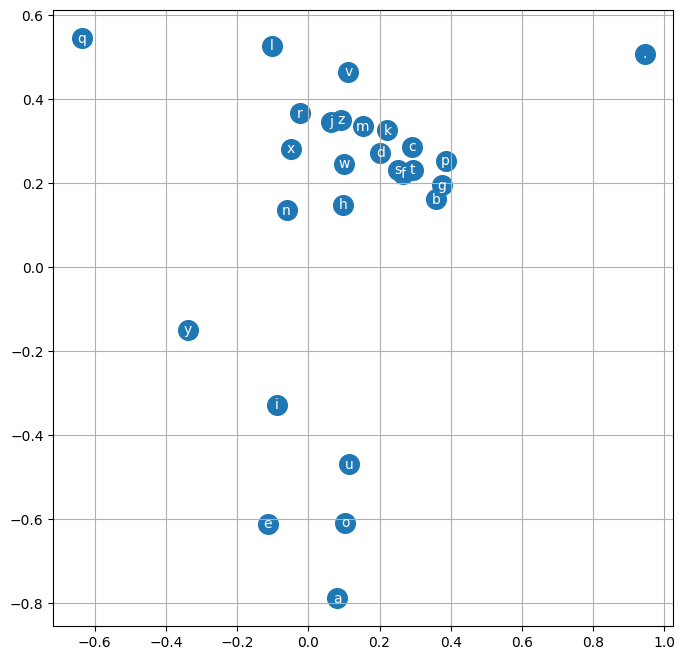

In [594]:
def plot_embeddings(model):
    # Unpack the model parameters (we only need the embedding matrix 'C' for plotting)
    C = model[0]

    # Set the size of the plot (8x8 inches), to make sure the points and labels are clear
    plt.figure(figsize=(8, 8))

    # Plot a scatter plot of the embeddings (C[:, 0] and C[:, 1] represent the x and y coordinates)
    # 's=200' makes each point larger, so they are easier to see
    plt.scatter(C[:, 0].data, C[:, 1].data, s=200)

    # Loop over each embedding to plot the character it represents
    for i in range(C.shape[0]):
        # Add the text label (character) at the corresponding (x, y) coordinates
        # 'ha="center"' and 'va="center"' center the label at each point
        # 'color="white"' ensures the text is visible on dark scatter points
        plt.text(C[i, 0].item(), C[i, 1].item(), itos_map[i], ha="center", va="center", color="white")

    # Add a grid with minor lines for better visualization
    plt.grid("minor")

plot_embeddings(model)

The positioning of the character embeddings shows that the model has learned certain patterns by placing characters with similar properties closer together. Some patterns that stand out:

- Vowels (`a`, `e`, `i`, `o`, `u`) are clustered together, suggesting the model has recognized that vowels behave differently from consonants. For example, consonant pairs (like `br` in "Brian") are more common than vowel pairs (like `ea` in "Leah") in American names.
- The `.` character is isolated, likely because it only appears at the start or end of a name.
- `y` is close to `i` because they are pronounced similarly and can sometimes be interchangeable.

There may be more patterns in the plot—can you spot any?

## THE END

For more **AI/ML** notebooks, check my repo: 🔗 https://github.com/tsilva/aiml-notebooks